In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import itertools
import calendar
import matplotlib
import datetime
import matplotlib.image as img
import matplotlib.pyplot as plt

from datetime import date
from pandasql import sqldf

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## The exercise description

You were asked by the head of product to review one of the A/B tests his team made some time
ago, because his expectations were not matching with results shown by Firebase. He wants you
to provide quick research, but did not provide you details on this test as he wants you to avoid
any biases related to his expectations.

Please, do your best, using any approaches and tools to provide analytical review and
conclusion on this A/B test. To explain your conclusions please prepare a few slides and do a
quick presentation on it.

For sure, as a Senior Data Analyst you have to ask as many questions as possible before you
start your research, but unfortunately in this case you were unable to discuss the test prior to
this exercise. 

If you have any question you want to ask regarding the conducted A/B test,
please write it down on a separate list in your presentation.
Your data engineers have provided you with 3 files related with this A/B test :

**abtest_distribution.csv**
- **eventtime** - Time when user was distributed to the particular group in this A/B test
- **user_id** - Unique user identifier
- **country** - Country - geo ip based position of user
- **abtest_group** - Group of AB test

**users.csv**
- **user_id** - Unique user identifier
- **User_create_time** - Datetime when user was registeren in our system
- **user_country** - Country - geo ip based position of user on registration time

**purchases.csv**
- **transaction_type** - Internal category of transactions, if you see ‘adjustment’ that means this is the operation of money return to user (return)
- **transaction_id** - Transaction identifier
- **payment_date** - Datetime of transaction
- **user_id** - Unique user identifier
- **product_type** - There are two types trial and purchase, trial has value =0 as it is not charging user
- **product** - Product code
- **Value** - Value of transaction you can assume it as amount of money company have got from purchase

## Downloading the data

In [5]:
abtest_distribution = 'abtest_distribution.csv'
users = 'users.csv'
purchases = 'purchases.csv'

In [6]:
df_abtest = pd.read_csv(abtest_distribution)
df_users = pd.read_csv(users)
df_purchases = pd.read_csv(purchases)

In [7]:
dfs = {
    abtest_distribution: df_abtest,
    users: df_users,
    purchases: df_purchases
}

## General information about the data

In [8]:
for name, df in dfs.items():
    print(name, df.shape)
    print(df.info(show_counts=True))
    print()
    print()

abtest_distribution.csv (48994, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48994 entries, 0 to 48993
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   eventtime     48994 non-null  object
 1   user_id       48994 non-null  int64 
 2   country       48986 non-null  object
 3   abtest_group  48994 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB
None


users.csv (48984, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48984 entries, 0 to 48983
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           48984 non-null  int64 
 1   user_create_time  48984 non-null  object
 2   user_country      48976 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None


purchases.csv (19334, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19334 entries, 0 to 19333
Data columns (total 7 columns):

In [9]:
for name, df in dfs.items():
    print(df.nunique())
    print()
    print()

eventtime       48916
user_id         47983
country           177
abtest_group        3
dtype: int64


user_id             47973
user_create_time    47969
user_country          179
dtype: int64


transaction_type        2
transaction_id      16245
payment_date        16124
user_id              7239
product_type            2
product                 3
value                   4
dtype: int64




In [10]:
df_abtest.head()

,eventtime,user_id,country,abtest_group
0,2022-02-06 13:26:53.734 UTC,39090121,DE,paywall_before_demo
1,2022-02-03 19:30:59.592 UTC,38882308,GB,old
2,2022-02-09 08:56:47.802 UTC,39191689,IT,paywall_before_demo
3,2022-02-04 21:07:38.543 UTC,38472344,IT,paywall_after_demo
4,2022-02-06 23:05:03.383 UTC,38786564,RS,old


In [11]:
df_abtest['eventtime'].min(), df_abtest['eventtime'].max()

('2021-12-09 10:12:46.891 UTC', '2022-02-09 23:48:01.9 UTC')

**I see, that test lasts 2 months**

In [12]:
df_users.head()

,user_id,user_create_time,user_country
0,24883424,2021-06-13 16:34:45 UTC,VN
1,24958769,2021-06-15 23:27:29 UTC,IL
2,24833272,2021-06-12 06:50:09 UTC,KG
3,24946150,2021-06-15 14:23:06 UTC,TW
4,24708975,2021-06-08 09:31:28 UTC,BN


In [13]:
df_users['user_create_time'].min(), df_users['user_create_time'].max()

('2014-09-06 04:40:00 UTC', '2022-02-09 08:56:36.535 UTC')

**Users have been registering for 8 years**

In [14]:
df_purchases.head()

,transaction_type,transaction_id,payment_date,user_id,product_type,product,value
0,original,5281490,2022-02-10 12:28:27,38474016,purchase,p2,12
1,original,5281490,2022-02-10 12:28:27,38474016,purchase,p2,12
2,original,5281166,2022-02-10 11:32:46,24774923,purchase,p1,2
3,adjustment,5270622,2022-02-10 11:31:35,23943924,purchase,p2,12
4,original,5281246,2022-02-10 11:30:39,34393505,purchase,p1,2


In [15]:
df_purchases['payment_date'].min(), df_purchases['payment_date'].max()

('2016-09-08 19:11:34', '2022-02-10 12:28:27')

**Users have been purchasing for 6 years**

## Data Processing

**df_abtest, df_users**

Let's take a closer look at the data

In [16]:
# amount of all values
df_abtest['user_id'].shape[0]

48994

In [17]:
# unique values only
df_abtest['user_id'].unique().shape[0]

47983

In [18]:
df_abtest['user_id'].shape[0] - df_abtest['user_id'].unique().shape[0]

1011

There are duplicates within the test results, I need to investigate why 

In [19]:
def size_calculation(df, groupby_columns, sort_columns=None, ascending=True):
    """
    Return grouped column with its size's value
    
    """
    sort_columns = sort_columns or groupby_columns
    
    return df.groupby(groupby_columns)                                        \
        .size()                                                               \
        .reset_index(name='cnt')                                              \
        .sort_values(by=sort_columns, ignore_index=True, ascending=ascending)

In [20]:
def get_samples(df, col, col_value):
    """
    Return rows from df where df[col] == col_value
    
    Parameters:
        df - dataframe
        col - selector column
        col_value - selector column value
    
    Returns:
        rows from df where df[col] == col_value
    """
    return df[df[col] == col_value] 

In [21]:
size_calculation(df_abtest, groupby_columns=['user_id'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,user_id,cnt
0,19513058,23
1,5946290,10
2,39135526,8
3,14608968,7
4,10256947,6
5,18586507,5
6,33888125,5
7,39015526,5
8,9068320,4
9,37702392,4


Let's delete duplicates in df_abtest

In [22]:
df_abtest.drop_duplicates(inplace=True)

In [23]:
df_abtest['user_id'].shape[0] - df_abtest['user_id'].unique().shape[0]

934

There are still duplicates, let's look closer

**Checking duplicates within ab-test and within user's table after deleting**

In [24]:
# checking df_abtest with random sample
get_samples(df_abtest, 'user_id', 19513058)[:10]

,eventtime,user_id,country,abtest_group
3454,2021-12-27 14:14:14.113 UTC,19513058,BY,old
4211,2021-12-22 07:33:17.405 UTC,19513058,BY,old
5687,2021-12-22 07:35:56.025 UTC,19513058,BY,old
6336,2021-12-28 17:35:27.337 UTC,19513058,BY,old
8253,2021-12-23 07:57:31.296 UTC,19513058,BY,old
8335,2021-12-21 14:34:19.318 UTC,19513058,BY,old
9646,2021-12-28 11:48:46.291 UTC,19513058,BY,old
10423,2021-12-27 13:37:10.126 UTC,19513058,BY,old
10673,2021-12-28 11:17:12.082 UTC,19513058,BY,old
20058,2021-12-28 16:11:26.981 UTC,19513058,BY,paywall_after_demo


In [25]:
# checking df_users with the same random sample
get_samples(df_users, 'user_id', 19513058)[:10]

,user_id,user_create_time,user_country
11068,19513058,2021-01-19 09:27:36 UTC,BY
11069,19513058,2021-01-19 09:27:36 UTC,BY
11070,19513058,2021-01-19 09:27:36 UTC,BY
11071,19513058,2021-01-19 09:27:36 UTC,BY
11072,19513058,2021-01-19 09:27:36 UTC,BY
11073,19513058,2021-01-19 09:27:36 UTC,BY
11074,19513058,2021-01-19 09:27:36 UTC,BY
11075,19513058,2021-01-19 09:27:36 UTC,BY
11076,19513058,2021-01-19 09:27:36 UTC,BY
11077,19513058,2021-01-19 09:27:36 UTC,BY


In [26]:
get_samples(df_abtest, 'user_id', 5946290)[:5]

,eventtime,user_id,country,abtest_group
7588,2021-12-21 14:35:22.709 UTC,5946290,LT,old
9002,2021-12-27 10:25:24.771 UTC,5946290,LT,old
15088,2021-12-21 13:19:11.326 UTC,5946290,LT,old
19978,2021-12-22 10:14:57.498 UTC,5946290,LT,paywall_after_demo
21771,2021-12-21 14:24:23.249 UTC,5946290,LT,paywall_after_demo


In [27]:
get_samples(df_users, 'user_id', 5946290)[:5]

,user_id,user_create_time,user_country
2250,5946290,2017-12-13 14:50:00 UTC,LT
2251,5946290,2017-12-13 14:50:00 UTC,LT
2252,5946290,2017-12-13 14:50:00 UTC,LT
2253,5946290,2017-12-13 14:50:00 UTC,LT
2254,5946290,2017-12-13 14:50:00 UTC,LT


**I suppose, that duplicates from the main table ended up in the ab-testing table, so we need to delete them both tables**

In [28]:
(df_users['user_id'].shape[0], df_users['user_id'].unique().shape[0])

(48984, 47973)

In [29]:
df_users['user_id'].shape[0] - df_users['user_id'].unique().shape[0] 

1011

In [30]:
df_users.drop_duplicates(inplace=True)

In [31]:
# checking duplicates within df_users_id

df_users['user_id'].shape[0] - df_users['user_id'].unique().shape[0] 

0

**Let's also remove all duplicates in df_abtest**

In [32]:
tdf = size_calculation(df_abtest, groupby_columns=['user_id'], 
                 sort_columns=['cnt'], ascending=False)
tdf[:10]

,user_id,cnt
0,19513058,23
1,5946290,10
2,14608968,7
3,10256947,6
4,18586507,5
5,37702392,4
6,21121251,4
7,9068320,4
8,39094612,4
9,39027331,4


In [33]:
duplicates_users = set(tdf[tdf['cnt'] > 1]['user_id'])

In [34]:
len(duplicates_users)

826

**I can't ask questions why the situation with 1 users in few groups occurs, so I remove them from distribution**

In [35]:
df_abtest_cleaned = df_abtest[~df_abtest['user_id'].isin(duplicates_users)]

df_abtest_cleaned

,eventtime,user_id,country,abtest_group
0,2022-02-06 13:26:53.734 UTC,39090121,DE,paywall_before_demo
1,2022-02-03 19:30:59.592 UTC,38882308,GB,old
2,2022-02-09 08:56:47.802 UTC,39191689,IT,paywall_before_demo
3,2022-02-04 21:07:38.543 UTC,38472344,IT,paywall_after_demo
4,2022-02-06 23:05:03.383 UTC,38786564,RS,old
...,...,...,...,...
48989,2021-12-21 18:36:04.713 UTC,7851926,RU,paywall_before_demo
48990,2021-12-21 11:58:32.24 UTC,17232574,RU,paywall_before_demo
48991,2021-12-26 21:48:27.809 UTC,31524128,RU,paywall_before_demo
48992,2021-12-26 15:58:04.317 UTC,9478019,RU,paywall_before_demo


In [36]:
df_abtest_cleaned['user_id'].shape[0] - df_abtest_cleaned['user_id'].unique().shape[0]

0

**After processing our data looks like this**

In [37]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47973 entries, 0 to 48983
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           47973 non-null  int64 
 1   user_create_time  47973 non-null  object
 2   user_country      47965 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [38]:
df_abtest_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47157 entries, 0 to 48993
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   eventtime     47157 non-null  object
 1   user_id       47157 non-null  int64 
 2   country       47149 non-null  object
 3   abtest_group  47157 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


I want to change the format for `eventtime` and add separate columns with `month` for future

In [39]:
df_abtest_cleaned['eventtime'] = df_abtest_cleaned['eventtime'].str[0:19]
df_abtest_cleaned['date'] = df_abtest_cleaned['eventtime'].str[0:10]

In [40]:
df_abtest_cleaned

,eventtime,user_id,country,abtest_group,date
0,2022-02-06 13:26:53,39090121,DE,paywall_before_demo,2022-02-06
1,2022-02-03 19:30:59,38882308,GB,old,2022-02-03
2,2022-02-09 08:56:47,39191689,IT,paywall_before_demo,2022-02-09
3,2022-02-04 21:07:38,38472344,IT,paywall_after_demo,2022-02-04
4,2022-02-06 23:05:03,38786564,RS,old,2022-02-06
...,...,...,...,...,...
48989,2021-12-21 18:36:04,7851926,RU,paywall_before_demo,2021-12-21
48990,2021-12-21 11:58:32,17232574,RU,paywall_before_demo,2021-12-21
48991,2021-12-26 21:48:27,31524128,RU,paywall_before_demo,2021-12-26
48992,2021-12-26 15:58:04,9478019,RU,paywall_before_demo,2021-12-26


<Axes: xlabel='date'>

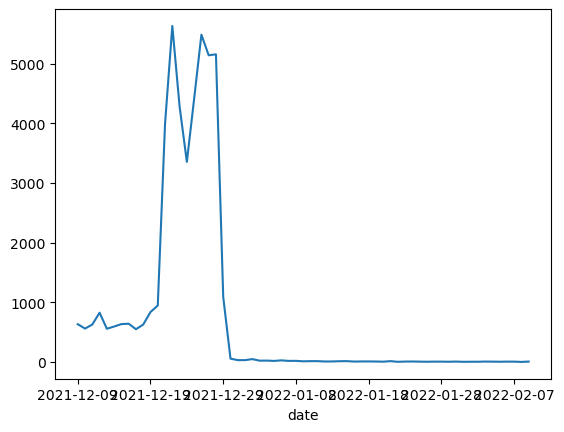

In [41]:
df_abtest_cleaned.groupby(['date']).size().plot()

In [42]:
df_abtest_cleaned.groupby(['date']).size()

date
2021-12-09     634
2021-12-10     561
2021-12-11     629
2021-12-12     827
2021-12-13     558
2021-12-14     595
2021-12-15     636
2021-12-16     642
2021-12-17     550
2021-12-18     628
2021-12-19     838
2021-12-20     947
2021-12-21    3992
2021-12-22    5632
2021-12-23    4283
2021-12-24    3354
2021-12-25    4410
2021-12-26    5486
2021-12-27    5140
2021-12-28    5156
2021-12-29    1090
2021-12-30      57
2021-12-31      32
2022-01-01      32
2022-01-02      49
2022-01-03      23
2022-01-04      24
2022-01-05      19
2022-01-06      28
2022-01-07      19
2022-01-08      20
2022-01-09      12
2022-01-10      15
2022-01-11      15
2022-01-12       9
2022-01-13      10
2022-01-14      14
2022-01-15      15
2022-01-16       8
2022-01-17      10
2022-01-18      10
2022-01-19       9
2022-01-20       6
2022-01-21      15
2022-01-22       4
2022-01-23       8
2022-01-24       9
2022-01-25       7
2022-01-26       5
2022-01-27       7
2022-01-28       7
2022-01-29       5
2022-01

**Most of the were users distributed to AB test in December**

In [43]:
df_abtest_cleaned.shape

(47157, 5)

In [44]:
size_calculation(df_abtest_cleaned, groupby_columns=['abtest_group'], 
                 sort_columns=['cnt'], ascending=False)

,abtest_group,cnt
0,old,15910
1,paywall_after_demo,15691
2,paywall_before_demo,15556


In [45]:
size_calculation(df_abtest_cleaned, groupby_columns=['abtest_group', 'country'], 
                 sort_columns=['cnt'], ascending=False)[:15]

,abtest_group,country,cnt
0,old,US,2695
1,paywall_before_demo,US,2649
2,paywall_after_demo,US,2620
3,paywall_before_demo,IT,2462
4,paywall_after_demo,IT,2432
5,old,IT,2361
6,paywall_after_demo,DE,2138
7,old,DE,2092
8,paywall_before_demo,DE,2066
9,old,RU,1638


**I see, that users were distributed in equal parts from each country for groups**

**df_purchases**

In [46]:
df_purchases.head()

,transaction_type,transaction_id,payment_date,user_id,product_type,product,value
0,original,5281490,2022-02-10 12:28:27,38474016,purchase,p2,12
1,original,5281490,2022-02-10 12:28:27,38474016,purchase,p2,12
2,original,5281166,2022-02-10 11:32:46,24774923,purchase,p1,2
3,adjustment,5270622,2022-02-10 11:31:35,23943924,purchase,p2,12
4,original,5281246,2022-02-10 11:30:39,34393505,purchase,p1,2


In [47]:
for colname in df_purchases.select_dtypes(include=['object', 'int64']).columns:
    print(str(colname) + '\n\n' + str(df_purchases[colname].value_counts()) + '\n' + '-' * 50 + '\n')

transaction_type

transaction_type
original      19102
adjustment      232
Name: count, dtype: int64
--------------------------------------------------

transaction_id

transaction_id
1467184    23
1457271    23
1437336    23
1437256    23
1437160    23
           ..
4858112     1
4858104     1
4858100     1
4858016     1
1085206     1
Name: count, Length: 16245, dtype: int64
--------------------------------------------------

payment_date

payment_date
2021-03-22 08:02:44    46
2021-03-22 13:02:44    23
2021-04-06 19:58:04    23
2021-02-25 14:55:31    23
2021-03-17 10:34:14    23
                       ..
2021-12-12 09:33:02     1
2021-12-12 09:20:22     1
2021-12-12 08:42:08     1
2021-12-12 08:24:32     1
2016-09-08 19:11:34     1
Name: count, Length: 16124, dtype: int64
--------------------------------------------------

user_id

user_id
19513058    2254
10256947      66
5946290       60
8273454       46
9987507       36
            ... 
37945216       1
37945852       1
39132070  

**Let's look at the values of df_purchases**

In [48]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19334 entries, 0 to 19333
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_type  19334 non-null  object
 1   transaction_id    19334 non-null  int64 
 2   payment_date      19334 non-null  object
 3   user_id           19334 non-null  int64 
 4   product_type      19334 non-null  object
 5   product           19334 non-null  object
 6   value             19334 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.0+ MB


In [49]:
df_purchases['transaction_id'].shape

(19334,)

In [50]:
df_purchases['transaction_id'].unique().shape

(16245,)

In [51]:
get_samples(df_purchases, 'transaction_id', 2187145.00)[:5]

,transaction_type,transaction_id,payment_date,user_id,product_type,product,value
8057,original,2187145,2021-11-07 16:01:32,18041026,trial,p2,0
8058,original,2187145,2021-11-07 16:01:32,18041026,trial,p2,0


Found duplicate values, let's remove

In [52]:
df_purchases.drop_duplicates(inplace=True)

In [53]:
df_purchases.shape

(16470, 7)

In [54]:
df_purchases['transaction_id'].unique().shape

(16245,)

In [55]:
df_purchases['transaction_type'].value_counts()

transaction_type
original      16245
adjustment      225
Name: count, dtype: int64

In [56]:
size_calculation(df_purchases, groupby_columns=['transaction_id'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,transaction_id,cnt
0,4884220,2
1,4911040,2
2,5188326,2
3,1824586,2
4,1446398,2
5,4874132,2
6,5123810,2
7,4902632,2
8,4936637,2
9,1617039,2


In [57]:
get_samples(df_purchases, 'transaction_id', 4884220)

,transaction_type,transaction_id,payment_date,user_id,product_type,product,value
5297,adjustment,4884220,2021-12-20 06:49:05,7718152,purchase,p2,12
5543,original,4884220,2021-12-18 22:47:24,7718152,purchase,p2,12


In [58]:
trs_ids_with_adj = set(df_purchases[df_purchases['transaction_type'] == 'adjustment']['transaction_id'])

In [59]:
tr_ids_isin_adj = df_purchases['transaction_id'].isin(trs_ids_with_adj)

In [60]:
df_trs = df_purchases[(df_purchases['transaction_type'] == 'adjustment') 
                      | ((df_purchases['transaction_type'] == 'original') & ~tr_ids_isin_adj)]
df_trs.shape[0]

16245

**When`transaction_id` had original and adjustment statuses, I decided to remain transaction_id with the `adjustment` status to check in which group there are the most cancellations and then - to delete them from analysis**

In [61]:
df_trs

,transaction_type,transaction_id,payment_date,user_id,product_type,product,value
0,original,5281490,2022-02-10 12:28:27,38474016,purchase,p2,12
2,original,5281166,2022-02-10 11:32:46,24774923,purchase,p1,2
3,adjustment,5270622,2022-02-10 11:31:35,23943924,purchase,p2,12
4,original,5281246,2022-02-10 11:30:39,34393505,purchase,p1,2
5,original,5280826,2022-02-10 10:29:15,37430841,purchase,p1,2
...,...,...,...,...,...,...,...
19329,original,2382345,2017-03-29 08:21:12,4525204,purchase,p3,1
19330,original,2381357,2017-03-27 02:34:09,4037885,purchase,p3,1
19331,original,2378737,2017-03-20 20:59:24,4566221,purchase,p3,1
19332,original,2367949,2017-02-22 22:44:01,5246034,purchase,p3,1


## Data ready for analysis

In [62]:
df_total = pd.merge(df_abtest_cleaned, df_trs, on=['user_id'], how='left')

In [63]:
df_total = df_total[(df_total['eventtime'] <= df_total['payment_date']) | (df_total['payment_date'].isna())]

In [64]:
df_total.head()

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
0,2022-02-06 13:26:53,39090121,DE,paywall_before_demo,2022-02-06,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-03 19:30:59,38882308,GB,old,2022-02-03,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-09 08:56:47,39191689,IT,paywall_before_demo,2022-02-09,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-04 21:07:38,38472344,IT,paywall_after_demo,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-02-06 23:05:03,38786564,RS,old,2022-02-06,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# amount of transactions
df_total['user_id'].shape[0]

44761

In [66]:
# amount of unique users
df_total['user_id'].unique().shape[0]

43807

In [67]:
# paying users
df_total[df_total['transaction_id'].notna()]['user_id'].shape[0]

4597

In [68]:
# paying unique users
df_total[df_total['transaction_id'].notna()]['user_id'].unique().shape[0]

3643

In [69]:
df_gr = df_total.groupby(by=['abtest_group', 'transaction_type'], as_index=False).agg(
    n_unq_users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    n_transactions=pd.NamedAgg(column='user_id', aggfunc='count'),
)

In [70]:
df_gr

,abtest_group,transaction_type,n_unq_users,n_transactions
0,old,adjustment,33,33
1,old,original,1355,1671
2,paywall_after_demo,adjustment,32,34
3,paywall_after_demo,original,943,1214
4,paywall_before_demo,adjustment,52,53
5,paywall_before_demo,original,1281,1592


**Adjustment to original transaction within groups by unique users and total transactions**

In [71]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [72]:
pd.DataFrame([
    {'abtest_group': 'old'                , 'adj_to_orig_ratio_users': 33 / 1355, 'adj_to_orig_ratio_trs': 33 / 1671},
    {'abtest_group': 'paywall_after_demo' , 'adj_to_orig_ratio_users': 32 / 943 , 'adj_to_orig_ratio_trs': 34 / 1214},
    {'abtest_group': 'paywall_before_demo', 'adj_to_orig_ratio_users': 52 / 1281, 'adj_to_orig_ratio_trs': 53 / 1592},
])

,abtest_group,adj_to_orig_ratio_users,adj_to_orig_ratio_trs
0,old,0.02435,0.01975
1,paywall_after_demo,0.03393,0.02801
2,paywall_before_demo,0.04059,0.03329


In [73]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

I saw, that the worst result has `paywall_before_demo`, but numbers of adjustments are so small

If a difference between groups will be not statistically significant, I'll return it

In [74]:
df_total.drop(df_total[df_total['transaction_type'] == 'adjustment'].index, inplace=True)

**So, now I'm ready to work with processed data**

From the whole view, I could see, that **p3 had minor values in all groups**

In [75]:
df_grouped_total = size_calculation(df_total, groupby_columns=['abtest_group', 'product_type', 'product', 'value'], 
                sort_columns=None, ascending=False)

df_grouped_total['total_value'] = df_grouped_total['value'] * df_grouped_total['cnt']
df_grouped_total

,abtest_group,product_type,product,value,cnt,total_value
0,paywall_before_demo,trial,p2,0.00,796,0.00
1,paywall_before_demo,purchase,p3,1.00,8,8.00
2,paywall_before_demo,purchase,p2,12.00,171,2052.00
3,paywall_before_demo,purchase,p1,2.00,617,1234.00
4,paywall_after_demo,trial,p2,0.00,464,0.00
5,paywall_after_demo,purchase,p3,1.00,5,5.00
6,paywall_after_demo,purchase,p2,12.00,138,1656.00
7,paywall_after_demo,purchase,p1,2.00,607,1214.00
8,old,trial,p2,0.00,798,0.00
9,old,purchase,p3,1.00,2,2.00


**I want to look at data in a few slices**

### Table 1 - abtest_group, value_per_user, value_per_paying_user

## A/B Testing Experimental Design

**1. Hypothesis**
Null hypothesis - 2 versions have the same conversion

**2. What the experience of the control and test groups looks like** 
- users in old version
- users with paywall_before_demo
- users with paywall_after_demo

**3. Which users are we testing on?**

- Random users (new and old)
- 65% of all users in equal parts: paywall_before_demo, paywall_after_demo
- 33% of users in old version

Time slot between ('2021-12-09', '2022-02-10')

**4. Key metrics for experiment evaluation**

- Conversion Rate =  Quantity of Paying Users / Quantity of Users

**5. Sample size**
- old - 14812
- paywall_before_demo - 14477
- paywall_after_demo - 14518

In [76]:
df_grouped = df_total.groupby(by='abtest_group', as_index=False).agg(
    n_unq_users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    sum_value=pd.NamedAgg(column='value', aggfunc='sum')
)

In [77]:
df_paying = df_total[df_total['transaction_id'].notna()]

df_paying_users = df_paying.groupby(by='abtest_group', as_index=False).agg(
    n_paying_users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    n_transactionids=pd.NamedAgg(column='transaction_id', aggfunc='count'),
)

In [78]:
df_results = pd.merge(df_grouped, df_paying_users, on=['abtest_group'])

df_results['arpu'] =  df_results['sum_value'] / df_results['n_unq_users']
df_results['arppu'] =  df_results['sum_value'] / df_results['n_paying_users']
df_results['conversion_rate'] = df_results['n_paying_users'] / df_results['n_unq_users']

In [79]:
df_results['paying_share'] = df_results['arpu'] / df_results['arppu'] 

In [80]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [81]:
df_results[['abtest_group', 'n_unq_users', 'conversion_rate', 'n_paying_users', 'sum_value', 'arpu', 'arppu', 'paying_share']]

,abtest_group,n_unq_users,conversion_rate,n_paying_users,sum_value,arpu,arppu,paying_share
0,old,14795,0.092,1355,3484.000,0.235,2.571,0.092
1,paywall_after_demo,14500,0.065,943,2875.000,0.198,3.049,0.065
2,paywall_before_demo,14448,0.089,1281,3294.000,0.228,2.571,0.089


In [82]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Considering the percentage of paying customers is important.

The point is that if ARPPU grows, but Paying Share falls, this will lead to a reduction in income - the profit from paying people will not be able to compensate for the reduction in their quantity. This metric helps you evaluate and predict your income.

### Comparing the conversions 

In [83]:
def conf_int(conv1, n1, conv2, n2, z):
    
    dconv = conv2 - conv1
    hlen = z * ( conv1 * (1 - conv1) / n1 + conv2 * (1 - conv2) / n2 )**0.5
    return (round(dconv - hlen, 4), round(dconv + hlen, 4))

In [84]:
def test_result(conf_int):
    if conf_int[0] <= 0 and 0 <= conf_int[1]:
        return 'not stat significant'
    else:
        return 'stat significant'

In [85]:
g_old, g_after, g_before = df_results['abtest_group']
n_old, n_after, n_before = df_results['n_unq_users']
conv_old, conv_after, conv_before = df_results['conversion_rate']

conf_int_old_vs_after    = conf_int(conv_old  , n_old  , conv_after , n_after , 1.96)
conf_int_old_vs_before   = conf_int(conv_old  , n_old  , conv_before, n_before, 1.96)
conf_int_after_vs_before = conf_int(conv_after, n_after, conv_before, n_before, 1.96)

In [86]:
# test conversion(group1) vs conversion(group2)
pd.DataFrame([
    {'group1': g_old, 'group2': g_after, 'conv1': conv_old, 'conv2': conv_after, 'diff': conv_after - conv_old,
        'conf_int': conf_int_old_vs_after, 'test_result': test_result(conf_int_old_vs_after)},
    
    {'group1': g_old, 'group2': g_before, 'conv1': conv_old, 'conv2': conv_before, 'diff': conv_before - conv_old,
        'conf_int': conf_int_old_vs_before, 'test_result': test_result(conf_int_old_vs_before)},
    
    {'group1': g_after, 'group2': g_before, 'conv1': conv_after, 'conv2': conv_before, 'diff': conv_before - conv_after,
        'conf_int': conf_int_after_vs_before, 'test_result': test_result(conf_int_after_vs_before)},
])

,group1,group2,conv1,conv2,diff,conf_int,test_result
0,old,paywall_after_demo,0.09,0.07,-0.03,"(-0.0327, -0.0204)",stat significant
1,old,paywall_before_demo,0.09,0.09,-0.00,"(-0.0095, 0.0036)",not stat significant
2,paywall_after_demo,paywall_before_demo,0.07,0.09,0.02,"(0.0175, 0.0298)",stat significant


### Conclusions:
1. In the test of **old VS paywall_after_demo** - **old version** group works better
2. In the test of **old VS paywall_before_demo** there is no statistically significant result
3. In the test of **paywall_after_demo VS paywall_before_demo** - the **paywall_before_demo** group works better

So, we can choose to remain **an old version** or move to **paywall_before_demo**

### Additions 1 - results by products

In [87]:
df_by_product = df_total.groupby(by=['product', 'abtest_group'], as_index=False).agg(
    n_unq_paying_users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    sum_value=pd.NamedAgg(column='value', aggfunc='sum')
)

df_by_product['arppu'] =  df_by_product['sum_value'] / df_by_product['n_unq_paying_users']

In [88]:
df_by_product

,product,abtest_group,n_unq_paying_users,sum_value,arppu
0,p1,old,503,1394.00,2.77
1,p1,paywall_after_demo,441,1214.00,2.75
2,p1,paywall_before_demo,450,1234.00,2.74
3,p2,old,869,2088.00,2.40
4,p2,paywall_after_demo,518,1656.00,3.20
5,p2,paywall_before_demo,854,2052.00,2.40
6,p3,old,2,2.00,1.00
7,p3,paywall_after_demo,4,5.00,1.25
8,p3,paywall_before_demo,6,8.00,1.33


Let's explain results above in a more detailed look:

- p3 - p3 had minor values in all groups and it's doesn't affect on the business
- p2 - had a trial subscription, had the highest arppu in paywall_after_demo group, but the biggest drawdown in paying users (and for us lowest revenue)
- p1 - paywall_after_demo and paywall_before_demo have a drawdown for paying users, unlike the old version

### Additions 2 - results by countries

I chose top 5 countries for looking in detail

In [89]:
tdf2 = df_total.groupby(['country']).size().reset_index(name='cnt') \
    .sort_values(by='cnt', ignore_index=True, ascending=False)[:5]

# Top 5 countries
set_countries = set(tdf2['country'])
set_countries

{'BR', 'DE', 'IT', 'RU', 'US'}

In [90]:
df_by_country = df_total.groupby(by=['country', 'abtest_group'], as_index=False).agg(
    n_unq_paying_users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    sum_value=pd.NamedAgg(column='value', aggfunc='sum')
)

df_by_country['arppu'] =  df_by_country['sum_value'] / df_by_country['n_unq_paying_users']

In [91]:
df_by_country[df_by_country['country'].isin(set_countries)].sort_values(by=['country', 'abtest_group'])

,country,abtest_group,n_unq_paying_users,sum_value,arppu
53,BR,old,944,208.00,0.22
54,BR,paywall_after_demo,815,133.00,0.16
55,BR,paywall_before_demo,886,232.00,0.26
93,DE,old,2025,246.00,0.12
94,DE,paywall_after_demo,2073,246.00,0.12
95,DE,paywall_before_demo,2011,152.00,0.08
194,IT,old,2282,224.00,0.10
195,IT,paywall_after_demo,2341,206.00,0.09
196,IT,paywall_before_demo,2380,245.00,0.10
358,RU,old,1440,326.00,0.23


- US had the highest values in all versions
- Results are different in each countries and in each different group, so I could conclude, that we need to have specific strategy for each country
- For instance:
ARPPU in RU for paywall_after_demo is the lowest, but ARPPU in DE for paywall_before_demo is the lowest

### Additions 3 - Purchases After Trial 

In [92]:
df_total

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
0,2022-02-06 13:26:53,39090121,DE,paywall_before_demo,2022-02-06,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-03 19:30:59,38882308,GB,old,2022-02-03,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-09 08:56:47,39191689,IT,paywall_before_demo,2022-02-09,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-04 21:07:38,38472344,IT,paywall_after_demo,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-02-06 23:05:03,38786564,RS,old,2022-02-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
55748,2021-12-23 21:37:12,38646460,RU,paywall_before_demo,2021-12-23,NaN,NaN,NaN,NaN,NaN,NaN
55750,2021-12-22 20:07:05,23120282,RU,paywall_before_demo,2021-12-22,NaN,NaN,NaN,NaN,NaN,NaN
55752,2021-12-21 11:58:32,17232574,RU,paywall_before_demo,2021-12-21,NaN,NaN,NaN,NaN,NaN,NaN
55753,2021-12-26 21:48:27,31524128,RU,paywall_before_demo,2021-12-26,original,5234542.00,2022-02-03 16:34:35,trial,p2,0.00


In [93]:
users_with_trial = set(df_total[df_total['product_type'] == 'trial']['user_id'])
len(users_with_trial)

2054

In [94]:
df_trials_purch = df_total[df_total['user_id'].isin(users_with_trial)]
df_trials_purch.sort_values(by=['user_id', 'payment_date'], inplace=True)

df_trials_purch.head()

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
16433,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5184150.00,2022-01-29 17:44:06,trial,p2,0.00
16432,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5206626.00,2022-02-01 21:57:01,purchase,p2,12.00
52807,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4915312.00,2021-12-24 03:26:53,trial,p2,0.00
52806,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4920958.00,2021-12-27 03:26:53,purchase,p2,12.00
49682,2021-12-18 11:15:09,2477007,IT,paywall_before_demo,2021-12-18,original,4921558.00,2021-12-27 08:39:37,trial,p2,0.00


In [95]:
size_calculation(df_trials_purch[df_trials_purch['product_type'] == 'trial'], groupby_columns=['user_id'], sort_columns=['cnt'])

,user_id,cnt
0,233835,1
1,39099010,1
2,39098893,1
3,39097204,1
4,39097117,1
...,...,...
2049,38795332,1
2050,39160237,2
2051,39071428,2
2052,38481292,2


In [96]:
get_samples(df_trials_purch, 'user_id', 39160237)

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
11705,2021-12-27 04:15:39,39160237,US,old,2021-12-27,original,4921054.00,2021-12-27 04:17:52,trial,p2,0.00
11704,2021-12-27 04:15:39,39160237,US,old,2021-12-27,original,4925761.00,2021-12-27 04:56:46,trial,p2,0.00
11703,2021-12-27 04:15:39,39160237,US,old,2021-12-27,original,4953409.00,2022-01-02 06:10:21,purchase,p2,12.00


In [97]:
get_samples(df_trials_purch, 'user_id', 39071428)

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
44086,2021-12-26 00:51:02,39071428,GB,paywall_before_demo,2021-12-26,original,4918195.00,2021-12-26 13:20:53,trial,p2,0.00
44085,2021-12-26 00:51:02,39071428,GB,paywall_before_demo,2021-12-26,original,4919002.00,2021-12-26 17:07:19,trial,p2,0.00


In [98]:
get_samples(df_trials_purch, 'user_id', 38481292)

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
3142,2021-12-18 21:49:57,38481292,DE,old,2021-12-18,original,4894636.00,2021-12-20 16:18:26,trial,p2,0.00
3141,2021-12-18 21:49:57,38481292,DE,old,2021-12-18,original,4894696.00,2021-12-20 16:40:14,trial,p2,0.00


In [99]:
get_samples(df_trials_purch, 'user_id', 38481292)

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
3142,2021-12-18 21:49:57,38481292,DE,old,2021-12-18,original,4894636.00,2021-12-20 16:18:26,trial,p2,0.00
3141,2021-12-18 21:49:57,38481292,DE,old,2021-12-18,original,4894696.00,2021-12-20 16:40:14,trial,p2,0.00


In [100]:
size_calculation(df_trials_purch, groupby_columns=['user_id'], sort_columns=['cnt'], ascending=False)

,user_id,cnt
0,17514406,4
1,39002473,4
2,21795752,4
3,39084493,3
4,39136435,3
...,...,...
2049,38838608,1
2050,38838592,1
2051,38838560,1
2052,38838316,1


In [101]:
get_samples(df_trials_purch, 'user_id', 17514406)

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value
4260,2021-12-22 22:39:51,17514406,US,old,2021-12-22,original,4905800.00,2021-12-23 00:18:55,purchase,p1,2.00
4259,2021-12-22 22:39:51,17514406,US,old,2021-12-22,original,5038578.00,2022-01-15 00:36:08,trial,p2,0.00
4258,2021-12-22 22:39:51,17514406,US,old,2021-12-22,original,5103278.00,2022-01-18 00:36:08,purchase,p2,12.00
4257,2021-12-22 22:39:51,17514406,US,old,2021-12-22,original,5138214.00,2022-01-23 00:18:55,purchase,p1,2.00


In [102]:
df_trials_max_date = df_trials_purch[df_trials_purch['product_type'] == 'trial'].groupby(by=['user_id'], as_index=False).agg(
    last_trial_date=pd.NamedAgg(column='payment_date', aggfunc='max')
)

df_trials_max_date

,user_id,last_trial_date
0,233835,2022-01-29 17:44:06
1,336772,2021-12-24 03:26:53
2,2477007,2021-12-27 08:39:37
3,4743817,2022-01-10 06:39:07
4,4960116,2021-12-22 04:58:49
...,...,...
2049,39360705,2021-12-30 00:23:32
2050,39361681,2021-12-29 17:55:14
2051,39362801,2021-12-29 06:19:51
2052,39362849,2021-12-29 06:27:51


In [103]:
df_trials_purch = df_trials_purch.merge(df_trials_max_date, on='user_id', how='left')

df_trials_purch

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value,last_trial_date
0,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5184150.00,2022-01-29 17:44:06,trial,p2,0.00,2022-01-29 17:44:06
1,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5206626.00,2022-02-01 21:57:01,purchase,p2,12.00,2022-01-29 17:44:06
2,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4915312.00,2021-12-24 03:26:53,trial,p2,0.00,2021-12-24 03:26:53
3,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4920958.00,2021-12-27 03:26:53,purchase,p2,12.00,2021-12-24 03:26:53
4,2021-12-18 11:15:09,2477007,IT,paywall_before_demo,2021-12-18,original,4921558.00,2021-12-27 08:39:37,trial,p2,0.00,2021-12-27 08:39:37
...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2021-12-29 05:37:47,39360705,US,paywall_before_demo,2021-12-29,original,4936437.00,2021-12-30 00:23:32,trial,p2,0.00,2021-12-30 00:23:32
2431,2021-12-29 05:56:54,39361681,BR,old,2021-12-29,original,4934705.00,2021-12-29 17:55:14,trial,p2,0.00,2021-12-29 17:55:14
2432,2021-12-29 06:18:16,39362801,US,old,2021-12-29,original,4931809.00,2021-12-29 06:19:51,trial,p2,0.00,2021-12-29 06:19:51
2433,2021-12-29 06:19:06,39362849,TH,old,2021-12-29,original,4931817.00,2021-12-29 06:27:51,trial,p2,0.00,2021-12-29 06:27:51


In [104]:
df_purch_after_trials = df_trials_purch[df_trials_purch['payment_date'] > df_trials_purch['last_trial_date']]

df_purch_after_trials

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value,last_trial_date
1,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5206626.00,2022-02-01 21:57:01,purchase,p2,12.00,2022-01-29 17:44:06
3,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4920958.00,2021-12-27 03:26:53,purchase,p2,12.00,2021-12-24 03:26:53
6,2021-12-22 12:52:58,4743817,RU,paywall_before_demo,2021-12-22,original,5026118.00,2022-01-13 07:00:37,purchase,p1,2.00,2022-01-10 06:39:07
9,2021-12-10 19:14:37,5311313,DE,old,2021-12-10,original,4896016.00,2021-12-20 21:37:59,purchase,p1,2.00,2021-12-10 19:16:50
10,2021-12-10 19:14:37,5311313,DE,old,2021-12-10,original,5123618.00,2022-01-20 21:37:59,purchase,p1,2.00,2021-12-10 19:16:50
...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2021-12-29 04:59:40,39358877,TR,paywall_after_demo,2021-12-29,original,4946669.00,2022-01-01 05:41:26,purchase,p2,12.00,2021-12-29 05:41:26
2418,2021-12-29 04:59:58,39358889,US,paywall_after_demo,2021-12-29,original,4946593.00,2022-01-01 05:00:33,purchase,p2,12.00,2021-12-29 05:00:33
2422,2021-12-29 05:16:03,39359701,US,paywall_before_demo,2021-12-29,original,4946641.00,2022-01-01 05:21:09,purchase,p2,12.00,2021-12-29 05:21:09
2425,2021-12-29 05:24:25,39360053,US,old,2021-12-29,original,4946637.00,2022-01-01 05:24:53,purchase,p2,12.00,2021-12-29 05:24:53


In [105]:
df_purch_after_tr_p2 = df_purch_after_trials[df_purch_after_trials['product'] == 'p2']

df_purch_after_tr_p2

,eventtime,user_id,country,abtest_group,date,transaction_type,transaction_id,payment_date,product_type,product,value,last_trial_date
1,2021-12-24 17:08:47,233835,RU,old,2021-12-24,original,5206626.00,2022-02-01 21:57:01,purchase,p2,12.00,2022-01-29 17:44:06
3,2021-12-23 03:21:57,336772,BR,paywall_before_demo,2021-12-23,original,4920958.00,2021-12-27 03:26:53,purchase,p2,12.00,2021-12-24 03:26:53
12,2021-12-21 06:42:13,5351875,IT,paywall_after_demo,2021-12-21,original,5041662.00,2022-01-15 11:52:00,purchase,p2,12.00,2022-01-12 11:52:00
16,2021-12-12 09:32:10,6062156,IT,paywall_after_demo,2021-12-12,original,5130622.00,2022-01-21 22:41:45,purchase,p2,12.00,2022-01-16 16:41:06
20,2021-12-24 20:13:21,6212975,IT,old,2021-12-24,original,4924149.00,2021-12-27 20:18:49,purchase,p2,12.00,2021-12-24 20:18:49
...,...,...,...,...,...,...,...,...,...,...,...,...
2411,2021-12-29 15:20:09,39357029,US,paywall_before_demo,2021-12-29,original,5007694.00,2022-01-01 16:21:18,purchase,p2,12.00,2021-12-29 16:21:18
2416,2021-12-29 04:59:40,39358877,TR,paywall_after_demo,2021-12-29,original,4946669.00,2022-01-01 05:41:26,purchase,p2,12.00,2021-12-29 05:41:26
2418,2021-12-29 04:59:58,39358889,US,paywall_after_demo,2021-12-29,original,4946593.00,2022-01-01 05:00:33,purchase,p2,12.00,2021-12-29 05:00:33
2422,2021-12-29 05:16:03,39359701,US,paywall_before_demo,2021-12-29,original,4946641.00,2022-01-01 05:21:09,purchase,p2,12.00,2021-12-29 05:21:09


In [106]:
tdf = df_trials_purch.groupby(by=['abtest_group'], as_index=False).agg(
    uniq_users_with_tr=pd.NamedAgg(column='user_id', aggfunc='nunique')
)

In [107]:
tdf2 = df_purch_after_trials.groupby(by=['abtest_group'], as_index=False).agg(
    uniq_users_purch_after_tr=pd.NamedAgg(column='user_id', aggfunc='nunique')
)

In [108]:
tdf_p2 = df_purch_after_tr_p2.groupby(by=['abtest_group'], as_index=False).agg(
    uniq_usr_purch_after_tr_p2=pd.NamedAgg(column='user_id', aggfunc='nunique')
)

In [109]:
res = tdf.merge(tdf2, on='abtest_group', how='inner')
res = res.merge(tdf_p2, on='abtest_group', how='inner')

In [110]:
res

,abtest_group,uniq_users_with_tr,uniq_users_purch_after_tr,uniq_usr_purch_after_tr_p2
0,old,796,116,100
1,paywall_after_demo,463,96,80
2,paywall_before_demo,795,137,111


In [111]:
res['conv'] = res['uniq_users_purch_after_tr'] / res['uniq_users_with_tr']

In [112]:
res['conv_p2'] = res['uniq_usr_purch_after_tr_p2'] / res['uniq_users_with_tr']

In [113]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [114]:
res

,abtest_group,uniq_users_with_tr,uniq_users_purch_after_tr,uniq_usr_purch_after_tr_p2,conv,conv_p2
0,old,796,116,100,0.15,0.13
1,paywall_after_demo,463,96,80,0.21,0.17
2,paywall_before_demo,795,137,111,0.17,0.14


I can see, that most of users proceed with the same p2 product after trial

In [115]:
test_result(conf_int(0.15, 796, 0.17, 795, 1.96))

'not stat significant'

**There are no significant difference in old version and paywall_before_demo in user's behavior**